# Policy Gradient-Based Deterministic Optimal Savings

Author: [John Stachurski](https://johnstachurski.net)

## Introduction

In this notebook we solve a deterministic infinite horizon optimal savings
problem using policy gradient ascent with JAX. 

Each policy is represented as a fully connected feed forward neural network.

Utility takes the CRRA form $u(c) = c^{1-\gamma} / (1-\gamma)$ and the discount factor is $\beta$.

Wealth evolves according to 

$$
    w' = R (w - c) 
$$

where $R > 0$ is the gross interest rate.  

To ensure stability we check that $\beta R^{1-\gamma} < 1$.

For this model, it is known that the optimal policy is $c = \kappa w$, where

$$
    \kappa := 1 - [\beta R^{1-\gamma}]^{1/\gamma}
$$

We use this known exact solution to check our numerical methods.

Initial wealth $w_0$ is fixed at 1.0, so the objective function is

$$
    \max_{\sigma \in \Sigma} v_\sigma(w_0)
    \quad \text{with} \quad w_0 := 1.0
$$

Here 

* $\Sigma$ is the set of all feasible policies and
* $v_\sigma(w)$ is the lifetime value of following stationary policy $\sigma$, given initial wealth $w$.

We begin with some imports

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import optax
import matplotlib.pyplot as plt
from functools import partial
from typing import NamedTuple

## Set up

We use a class called `Model` to store model parameters.

In [2]:
class Model(NamedTuple):
    """
    Stores parameters for the model.

    """
    γ: float = 0.2
    β: float = 0.96
    R: float = 1.01

We use a class called `LayerParams` to store parameters representing a single
layer of the neural network.

In [3]:
class LayerParams(NamedTuple):
    """
    Stores parameters for one layer of the neural network.

    """
    W: jnp.ndarray     # weights
    b: jnp.ndarray     # biases

The next class stores some fixed values that form part of the network training
configuration.

In [4]:
class Config:
    """
    Configuration and parameters for training the neural network.

    """
    seed = 42                    # Seed for network initialization
    epochs = 400                 # No of training epochs
    path_length = 500            # Length of each consumption path
    layer_sizes = 1, 32, 32, 1   # Network layer sizes
    init_lr = 0.001              # Learning rate schedule parameter
    min_lr = 0.000005            # Learning rate schedule parameter
    warmup_steps = 200           # Learning rate schedule parameter
    decay_steps = 700            # Learning rate schedule parameter

The following function initializes a single layer of the network using Le Cun
initialization.

(Le Cun initialization is thought to pair well with `selu` activation.)

In [5]:
def initialize_layer(in_dim, out_dim, key):
    """
    Initialize weights and biases for a single layer of a the network.
    Use LeCun initialization.

    """
    s = jnp.sqrt(1.0 / in_dim)
    W = jax.random.normal(key, (in_dim, out_dim)) * s
    b = jnp.zeros((out_dim,))
    return LayerParams(W, b)

The next function builds an entire network, as represented by its parameters, by
initializing layers and stacking them into a list.

In [6]:
def initialize_network(key, layer_sizes):
    """
    Build a network by initializing all of the parameters.
    A network is a list of LayerParams instances, each 
    containing a weight-bias pair (W, b).

    """
    params = []
    # For all layers but the output layer
    for i in range(len(layer_sizes) - 1):
        # Build the layer 
        key, subkey = jax.random.split(key)
        layer = initialize_layer(
            layer_sizes[i],      # in dimension for layer
            layer_sizes[i + 1],  # out dimension for layer
            subkey 
        )
        # And add it to the parameter list
        params.append(layer)

    return params

Now we provide a function to do a forward pass through the network, given the
parameters.

In [7]:
def forward(params, w):
    """
    Evaluate neural network policy: maps a given wealth level w to
    consumption rate c/w by running a forward pass through the network.

    """
    σ = jax.nn.selu          # Activation function
    x = jnp.array((w,))      # Make state a 1D array
    # Forward pass through network, without the last step
    for W, b in params[:-1]:
        x = σ(x @ W + b)
    # Complete with sigmoid activation for consumption rate
    # Direct output in [0, 0.99] range
    W, b = params[-1]
    x = jax.nn.sigmoid(x @ W + b) * 0.99  # Direct output in [0, 0.99]
    # Extract and return consumption rate
    consumption_rate = x[0]
    return consumption_rate

We use CRRA utility.

In [8]:
def u(c, γ):
    """ Utility function. """
    c = jnp.maximum(c, 1e-10)
    return c**(1 - γ) / (1 - γ)

The next function approximates lifetime value associated with a given policy, as
represented by the parameters of a neural network.

In [9]:
@partial(jax.jit, static_argnames=('path_length'))
def compute_lifetime_value(params, model, path_length):
    """
    Compute the lifetime value of a path generated from
    the policy embedded in params and the initial condition w_0 = 1.

    """
    γ, β, R = model.γ, model.β, model.R
    initial_w = 1.0

    def update(t, state):
        # Unpack and compute consumption given current wealth
        w, value, discount = state
        consumption_rate = forward(params, w)
        c = consumption_rate * w
        # Update loop state and return it
        w = R * (w - c)
        value = value + discount * u(c, γ)
        discount = discount * β
        new_state = w, value, discount
        return new_state

    initial_value, initial_discount = 0.0, 1.0
    initial_state = initial_w, initial_value, initial_discount
    final_w, final_value, discount = jax.lax.fori_loop(
        0, path_length, update, initial_state
    )
    return final_value

Here's the loss function we will minimize.


In [10]:
def loss_function(params, model, path_length):
    """
    Loss is the negation of the lifetime value of the policy 
    identified by `params`.

    """
    return -compute_lifetime_value(params, model, path_length)

We create a standard Optax learning rate scheduler, which controls the time path
of the learning parameter over the process of gradient descent.

In [11]:
def create_lr_schedule():
    warmup_fn = optax.linear_schedule(
        init_value=0.0,
        end_value=Config.init_lr,
        transition_steps=Config.warmup_steps
    )
    
    decay_fn = optax.exponential_decay(
        init_value=Config.init_lr,
        transition_steps=Config.decay_steps,
        decay_rate=0.5,
        end_value=Config.min_lr
    )
    
    return optax.join_schedules(
        schedules=[warmup_fn, decay_fn],
        boundaries=[Config.warmup_steps]
    )

## Train and solve 

First we create an instance of the model and unpack names

In [12]:
model = Model()
γ, β, R = model.γ, model.β, model.R
seed, epochs = Config.seed, Config.epochs
path_length = Config.path_length
layer_sizes = Config.layer_sizes

We test stability.

In [13]:
assert β * R**(1 - γ) < 1, "Parameters fail stability test."

We compute the optimal consumption rate and lifetime value from the analytical
expressions.

In [14]:

κ = 1 - (β * R**(1 - γ))**(1/γ)
print(f"Optimal consumption rate = {κ}.\n")
v_max = κ**(-γ) * u(1.0, γ)
print(f"Theoretical maximum lifetime value = {v_max}.\n")

Optimal consumption rate = 0.15151990123292292.



Theoretical maximum lifetime value = 1.8231234550476074.



Let's now create a learning rate schedule and set up the Optax minimizer, using
[Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam).

In [15]:
lr_schedule = create_lr_schedule()
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),  # Gradient clipping for stability
    optax.adam(learning_rate=lr_schedule)
)

We initialize the parameters in the neural network and the state of the
optimizer.

In [16]:
key = random.PRNGKey(seed)
params = initialize_network(key, layer_sizes)
opt_state = optimizer.init(params)

Now let's train the network.

In [17]:
value_history = []
best_value = -jnp.inf
best_params = params
for i in range(epochs):

    # Compute value and gradients at existing parameterization
    loss, grads = jax.value_and_grad(loss_function)(params, model, path_length)
    lifetime_value = - loss
    value_history.append(lifetime_value)

    # Track best parameters
    if lifetime_value > best_value:
        best_value = lifetime_value
        best_params = params

    # Update parameters using optimizer
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    if i % 100 == 0:
        print(f"Iteration {i}: Value = {lifetime_value:.4f}")

# Use best parameters instead of final
params = best_params
print(f"\nBest value: {best_value:.4f}")
print(f"Final value: {value_history[-1]:.4f}")

Iteration 0: Value = 1.6888


Iteration 100: Value = 1.7997


Iteration 200: Value = 1.8200


Iteration 300: Value = 1.8225



Best value: 1.8227
Final value: 1.8227


First we plot the evolution of lifetime value over the epochs.

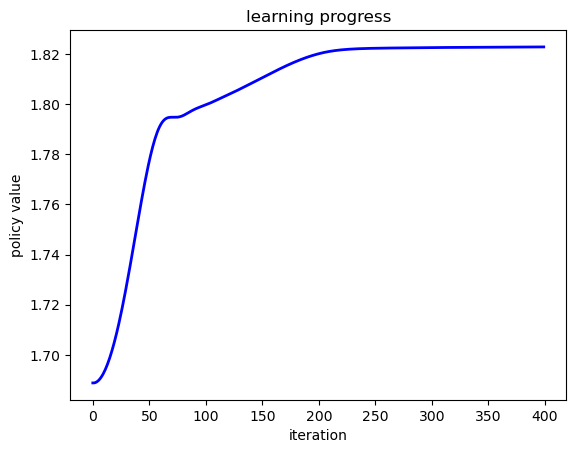

In [18]:
# Plot learning progress
fig, ax = plt.subplots()
ax.plot(value_history, 'b-', linewidth=2)
ax.set_xlabel('iteration')
ax.set_ylabel('policy value')
ax.set_title('learning progress')
plt.show()

Next we compare the learned and optimal policies.

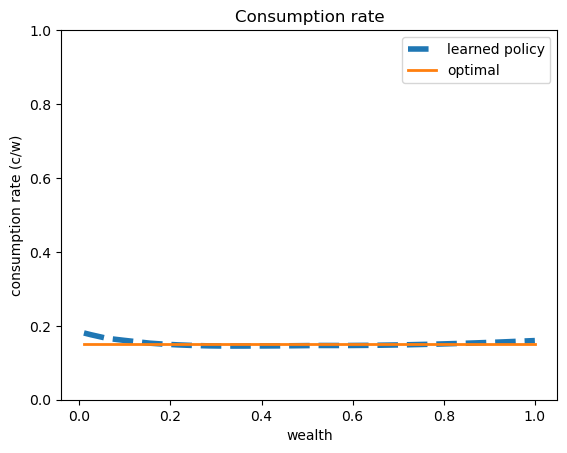

In [19]:
w_grid = jnp.linspace(0.01, 1.0, 1000)
policy_vmap = jax.vmap(lambda w: forward(params, w))
consumption_rate = policy_vmap(w_grid)
fig, ax = plt.subplots()
ax.plot(w_grid, consumption_rate, linestyle='--', lw=4, label='learned policy')
ax.plot(w_grid, κ * jnp.ones(len(w_grid)), lw=2, label='optimal')
ax.set_xlabel('wealth')
ax.set_ylabel('consumption rate (c/w)')
ax.set_title('Consumption rate')
ax.set_ylim(0, 1)
ax.legend()
plt.show()

Let's have a look at paths for consumption and wealth under the learned and
optimal policies.

The figures below show that the learned policies are close to optimal.

In [20]:
def simulate_consumption_path(params, T=120):
    """
    Compute consumption path using neural network policy identified by params.

    """
    w_sim = [1.0]   # 1.0 is the initial wealth
    c_sim = []
    w_opt = [1.0]
    c_opt = []

    w = 1.0
    for t in range(T):

        # Update policy path - forward returns consumption rate
        c = forward(params, w) * w
        c_sim.append(float(c))
        w = R * (w - c)
        w_sim.append(float(w))

        if w <= 1e-10:
            break

    w = 1.0
    for t in range(T):

        # Update optimal path
        c = κ * w
        c_opt.append(c)
        w = R * (w - c)
        w_opt.append(w)

        if w <= 1e-10:
            break

    return w_sim, c_sim, w_opt, c_opt

In [21]:
# Simulate and plot path
w_sim, c_sim, w_opt, c_opt = simulate_consumption_path(params)

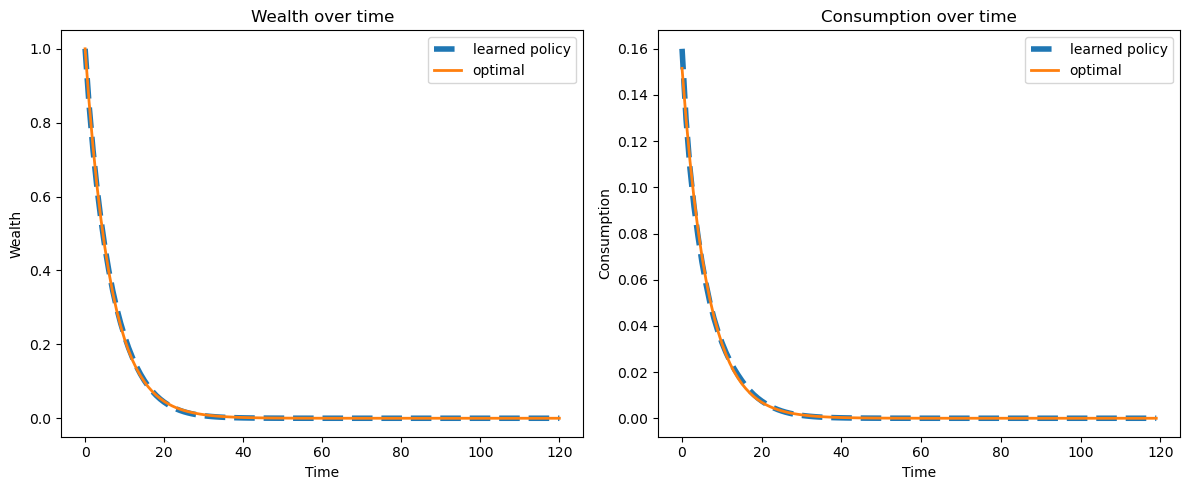

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(w_sim, lw=4, linestyle='--', label='learned policy')
ax1.plot(w_opt, lw=2, label='optimal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Wealth')
ax1.set_title('Wealth over time')
ax1.legend()

ax2.plot(c_sim, lw=4, linestyle='--', label='learned policy')
ax2.plot(c_opt, lw=2, label='optimal')
ax2.set_xlabel('Time')
ax2.set_ylabel('Consumption')
ax2.set_title('Consumption over time')
ax2.legend()

plt.tight_layout()
plt.show()